# Learn a Koopman model using Extended Dynamic Mode Decomposition (EDMD)
In this example, we will train a linear Koopman model using EDMD (see Williams,
Kevrekidis & Rowley, _"A Data–Driven Approximation of the Koopman Operator: Extending
 Dynamic Mode Decomposition"_, Journal of Nonlinear Science 25, pp. 1307-1346, 2015)
for a nonlinear, dynamical system. The approach is demonstrated for discrete-time Van
 der Pol system in reverse time:

$$x_{k+1} = x_k - y_k dt,\\
y_{k+1} = y_k + (x_k-y_k+x_k^2y_k)dt$$

where $dt=0.1$ (this is example II from Surana & Banaszuk, _"Linear observer synthesis
for nonlinear systems using Koopman Operator framework"_, IFAC 49-18 (2016), pp.
716-723).

In [1]:
import pykoopman as pk
import numpy as np
import numpy.random as rnd
np.random.seed(42)  # for reproducibility
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from pykoopman.common import rev_dvdp  # discrete-time, reverse-time van der Pol

### Collect training data
The training data consists of a snapshot pair taken from 51 uniformly distributed
random initial conditions.

In [2]:
n_states = 2  # Number of states
dT = 0.1      # Timestep
n_traj = 51   # Number of trajectories
n_int = 1     # Integration length

# Uniform distribution of initial conditions
x = xE = 2*rnd.random([n_states, n_traj])-1

# Init
X = np.zeros((n_states, n_int*n_traj))
Y = np.zeros((n_states, n_int*n_traj))

# Integrate
for step in range(n_int):
    y = rev_dvdp(0, x, 0, dT)
    X[:, (step)*n_traj:(step+1)*n_traj] = x
    Y[:, (step)*n_traj:(step+1)*n_traj] = y
    x = y

[Text(0, 0.5, '$x_2$'), Text(0.5, 0, '$x_1$')]

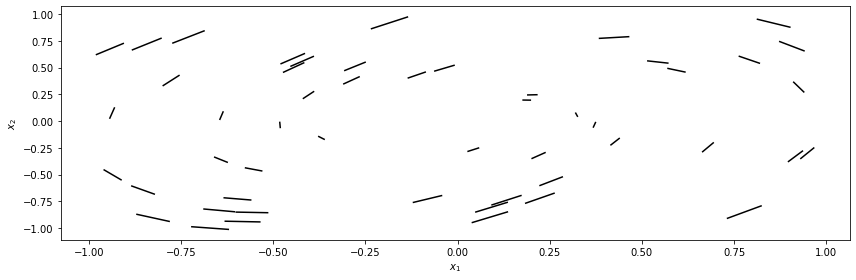

In [3]:
# Visualize first 100 steps of the training data
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(12, 4))
for traj_idx in range(n_traj):
    axs.plot([X[0, traj_idx::n_traj], Y[0, traj_idx::n_traj]],
             [X[1, traj_idx::n_traj], Y[1, traj_idx::n_traj]], '-k')
axs.set(
        ylabel=r'$x_2$',
        xlabel=r'$x_1$')

### Koopman regression using EDMD
As basis functions we choose thinplate radial basis functions.

In [4]:
EDMD = pk.regression.EDMD()
RBF = pk.observables.RadialBasisFunction(rbf_type='thinplate', n_centers=20,
                                         centers=None, kernel_width=1.0, polyharmonic_coeff=1.0, include_states=True)

model = pk.Koopman(observables=RBF, regressor=EDMD)
model.fit(X.T, y=Y.T)

Koopman(observables=RadialBasisFunction(centers=array([[-0.4302924 ,  0.00214365,  0.8905427 , -0.57516255, -0.21648001,
         0.55206724, -0.62079437, -0.95883101, -0.48507654, -0.77126021,
         0.9398197 ,  0.66911726,  0.2800954 ,  0.81014979,  0.65921273,
        -0.71481895,  0.85712724,  0.0706592 ,  0.66760268,  0.86499222],
       [-0.35619173, -0.77922241, -0.53941547, -0.13424353,  0.66096883,
         0.74786456, -0.98895577,  0.03590226, -0.15396946, -0.5512699 ,
        -0.75925917, -0.31629614,  0.91503951, -0.3456146 ,  0.05226458,
         0.42703572, -0.26337563,  0.97377387,  0.95478435, -0.49090383]]),
                                        n_centers=20, rbf_type='thinplate'),
        regressor=EDMD())

### Prediction
First, we will use the fitted EDMD model to predict the evolution for a single
initial condition. The inverse transformation, i.e. from observables back to the
state, is estimated using least-squares regression within the Koopman regressor.
Afterwards, we will show the prediction performance for the training data.

In [5]:
# x0 = [0.6, -0.6]
x0 = np.array([-0.3, -0.2])
T = 10
t = np.arange(0, T, dT)

# Integrate
Xtrue = np.zeros((len(t), n_states))
Xtrue[0, :] = x0
for step in range(len(t)-1):
    y = rev_dvdp(0, Xtrue[step, :][:, np.newaxis], 0, dT)
    Xtrue[step+1, :] = y

# Simulate (multi-step prediction) Koopman model
Xkoop = model.simulate(x0[np.newaxis, :], n_steps=len(t)-1)
Xkoop = np.vstack([x0[np.newaxis,:], Xkoop])

[Text(0, 0.5, '$x_2$'), Text(0.5, 0, '$t$')]

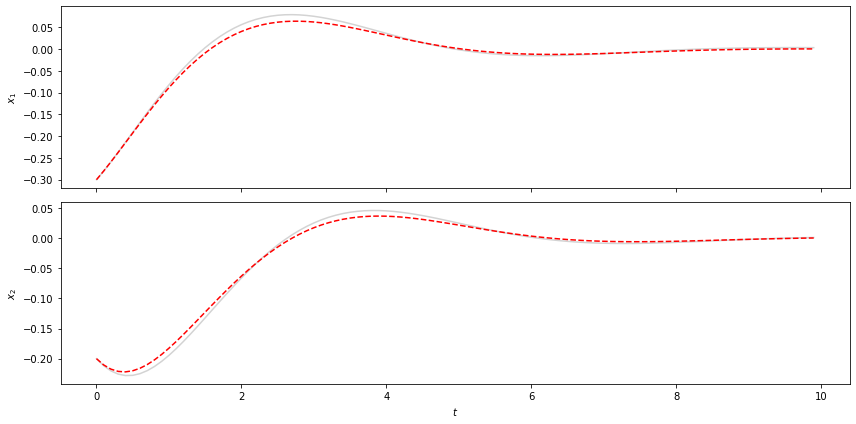

In [6]:
fig, axs = plt.subplots(2, 1, sharex=True, tight_layout=True, figsize=(12, 6))
axs[0].plot(t, Xtrue[:, 0], '-', color='lightgrey', label='True')
axs[0].plot(t, Xkoop[:, 0], '--r', label='EDMDc')
axs[0].set(ylabel=r'$x_1$')
axs[1].plot(t, Xtrue[:, 1], '-', color='lightgrey', label='True')
axs[1].plot(t, Xkoop[:, 1], '--r', label='EDMDc')
axs[1].set(
        ylabel=r'$x_2$',
        xlabel=r'$t$')

In [7]:
# Init
Xk = np.zeros((n_states, n_traj))
Yk = np.zeros((n_states, n_traj))

# 1-step prediction using Koopman model
for i in range(np.shape(xE)[1]):
    x0 = xE[:, i]
    y = model.predict(x0[np.newaxis, :])
    Xk[:, i] = x0
    Yk[:, i] = y

[Text(0, 0.5, '$x_2$'), Text(0.5, 0, '$x_1$')]

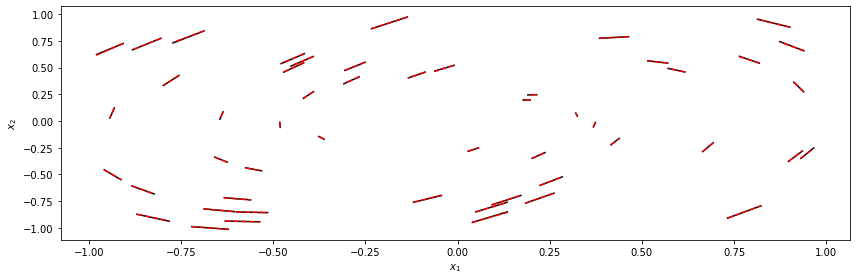

In [8]:
# Visualize
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(12, 4))
for traj_idx in range(n_traj):
    axs.plot([X[0, traj_idx::n_traj], Y[0, traj_idx::n_traj]],
             [X[1, traj_idx::n_traj], Y[1, traj_idx::n_traj]], '-k')
    axs.plot([Xk[0, traj_idx::n_traj], Yk[0, traj_idx::n_traj]],
             [Xk[1, traj_idx::n_traj], Yk[1, traj_idx::n_traj]], '--r')
axs.set(
        ylabel=r'$x_2$',
        xlabel=r'$x_1$')